In [43]:
import pandas as pd
import numpy as np
import pyreadr
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sc
from statsmodels.stats.power import TTestIndPower
from rpy2.robjects.conversion import localconverter
import math
sns.set_theme()

In [44]:
res = pyreadr.read_r('nh1516_pt1.rds')
res2 = pyreadr.read_r('nh1516_pt2.rds')

In [45]:
nh1516_pt1 = res[None]
nh1516_pt2 = res2[None]

In [46]:
df = nh1516_pt1

## Part 1

In [47]:
df['cdc'] = df['bmi'].apply(lambda x: "underweight" if 0<x<18.5 else
                           "healthy" if 18.5<=x<25 else
                            "overweight" if 25<=x<30 else
                            "obesity" if 30<=x else None
                           )
df.cdc.unique()

array(['healthy', 'obesity', 'overweight', 'underweight'], dtype=object)

*Function to use sampling with R seed for three strategies:*

In [48]:
def Sampling(df, seed, N, strategy):
    with localconverter(robjects.default_converter + pandas2ri.converter):
        r_from_pd_df = robjects.conversion.py2rpy(df)
        r_from_pd_df
        robjects.globalenv['r_from_pd_df'] = r_from_pd_df
        robjects.globalenv['seed'] = seed
        robjects.globalenv['N'] = N
    if(strategy == 'a'):
        data = robjects.r("""
        library(tidyverse)
        set.seed(seed)
        strat_a <- sample_n(r_from_pd_df, N)
        """)
    if(strategy == 'b'):
        data = robjects.r("""
        library(tidyverse)
        set.seed(seed)
        strat_b1 <- r_from_pd_df %>% group_by(obesity_b) %>% sample_n(15)
        """)
    if(strategy == 'c'):
        data = robjects.r("""
        library(tidyverse)
        set.seed(seed)
        strat_b1 <- r_from_pd_df %>% group_by(obesity_c) %>% sample_n(15)
        """)
        

    with localconverter(robjects.default_converter + pandas2ri.converter):
       r_df = robjects.conversion.rpy2py(data)
    return r_df



* Strategy A:

In [49]:
strat_a1 = Sampling(df, 10032, 30, 'a').reset_index().drop('index',axis = 1)
strat_a2 = Sampling(df, 10027, 30, 'a').reset_index().drop('index',axis = 1)
n = strat_a1.shape[0]
print('Seed 10032:\n''N:\n', strat_a1.cdc.value_counts(), '\nProportion: \n', strat_a1.cdc.value_counts()/n)
print('Seed 10027:\n''N:\n', strat_a2.cdc.value_counts(), '\nProportion: \n', strat_a2.cdc.value_counts()/n)



Seed 10032:
N:
 obesity        15
overweight      7
healthy         7
underweight     1
Name: cdc, dtype: int64 
Proportion: 
 obesity        0.500000
overweight     0.233333
healthy        0.233333
underweight    0.033333
Name: cdc, dtype: float64
Seed 10027:
N:
 obesity        12
healthy        10
overweight      6
underweight     2
Name: cdc, dtype: int64 
Proportion: 
 obesity        0.400000
healthy        0.333333
overweight     0.200000
underweight    0.066667
Name: cdc, dtype: float64


* Strategy B:

In [50]:
df_b = df
df_b['obesity_b'] = df['cdc'].apply(lambda x: "obese" if x == "obesity" else "non-obese")
strat_b1 = Sampling(df_b, 10032, 15, 'b')
strat_b2 = Sampling(df_b, 10027, 15, 'b')
print('Seed 10032:\n''N:\n',
      strat_b1.cdc.value_counts(),'\nProportion: \n', strat_b1.cdc.value_counts()/n)
print('Seed 10027:\n''N:\n', strat_b2.cdc.value_counts(), '\nProportion: \n', strat_b2.cdc.value_counts()/n)



Seed 10032:
N:
 obesity       15
overweight    10
healthy        5
Name: cdc, dtype: int64 
Proportion: 
 obesity       0.500000
overweight    0.333333
healthy       0.166667
Name: cdc, dtype: float64
Seed 10027:
N:
 obesity       15
overweight     8
healthy        7
Name: cdc, dtype: int64 
Proportion: 
 obesity       0.500000
overweight    0.266667
healthy       0.233333
Name: cdc, dtype: float64


* Strategy C:


In [51]:
df_c = df
df_c['obesity_c'] = df['cdc'].apply(lambda x: "obese" if x == "obesity" else
                                    "non-obese" if x == 'healthy' else None)
df_c = df_c[df_c.obesity_c.notna()]
strat_c1 = Sampling(df_c, 10032, 15, 'c')
strat_c2 = Sampling(df_c, 10027, 15, 'c')

print('Seed 10032:\n''N:\n', strat_c1.cdc.value_counts(), 
      '\nProportion: \n', strat_c1.cdc.value_counts()/n)
print('Seed 10027:\n''N:\n', strat_c2.cdc.value_counts(), '\nProportion: \n', strat_c2.cdc.value_counts()/n)



Seed 10032:
N:
 healthy    15
obesity    15
Name: cdc, dtype: int64 
Proportion: 
 healthy    0.5
obesity    0.5
Name: cdc, dtype: float64
Seed 10027:
N:
 healthy    15
obesity    15
Name: cdc, dtype: int64 
Proportion: 
 healthy    0.5
obesity    0.5
Name: cdc, dtype: float64


## Part 2

*Graphics:*

[Text(0.5, 1.0, 'Ln(Pfos)')]

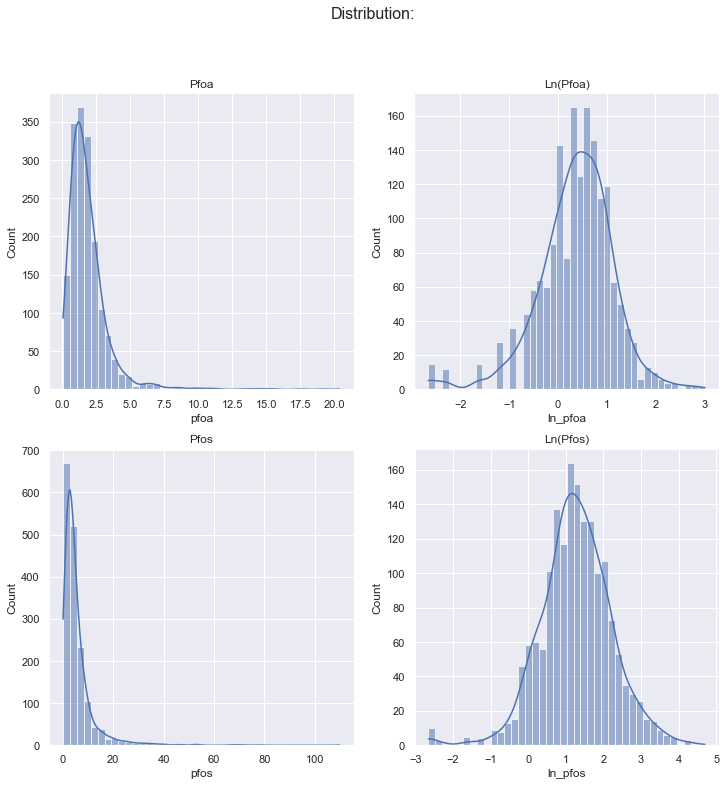

In [52]:
df2 = nh1516_pt2
f, axes = plt.subplots(2,2, figsize = (12,12))
f.suptitle('Distribution:', fontsize=16)
sns.histplot(data=df2,x = "pfoa", kde=True,ax = axes[0,0], bins = 40).set(title='Pfoa')
df2['ln_pfoa'] = np.log(df2['pfoa'])
sns.histplot(data=df2,x = "ln_pfoa", kde=True,ax = axes[0,1]).set(title='Ln(Pfoa)')
sns.histplot(data=df2,x = "pfos", kde=True,ax = axes[1,0], bins = 40).set(title='Pfos')
df2['ln_pfos'] = np.log(df2['pfos'])
sns.histplot(data=df2,x = "ln_pfos", kde=True,ax = axes[1,1]).set(title='Ln(Pfos)')




In [53]:
strat_ax1 = pd.merge(strat_a1 , df2 , on="SEQN", how='inner')
strat_ax2 = pd.merge(strat_a2 , df2 , on="SEQN", how='inner')

strat_bx1 = pd.merge(strat_b1 , df2 , on="SEQN", how='inner')
strat_bx2 = pd.merge(strat_b2 , df2 , on="SEQN", how='inner')

strat_cx1 = pd.merge(strat_c1 , df2 , on="SEQN", how='inner')
strat_cx2 = pd.merge(strat_c2 , df2 , on="SEQN", how='inner')

* Strategy A:

In [54]:
#seed 10032
strat_ax1['obesity_a'] = strat_ax1['cdc'].apply(lambda x: "obese" if x == "obesity" else "non-obese")
print(strat_ax1.groupby('obesity_a').describe(percentiles=[])[['ln_pfoa']])
print(strat_ax1.groupby('obesity_a').describe(percentiles=[])[['ln_pfos']])

          ln_pfoa                                                  
            count      mean       std       min       50%       max
obesity_a                                                          
non-obese    15.0  0.525239  0.767086 -0.693147  0.336472  2.442347
obese        15.0  0.475411  0.546915 -0.916291  0.470004  1.360977
          ln_pfos                                                  
            count      mean       std       min       50%       max
obesity_a                                                          
non-obese    15.0  1.458197  0.967086 -0.356675  1.722767  3.693867
obese        15.0  1.227461  0.656381  0.182322  1.308333  2.197225


In [55]:
#seed 10027
strat_ax2['obesity_a'] = strat_ax2['cdc'].apply(lambda x: "obese" if x == "obesity" else "non-obese")
print(strat_ax2.groupby('obesity_a').describe(percentiles=[])[['ln_pfoa']])
print(strat_ax2.groupby('obesity_a').describe(percentiles=[])[['ln_pfos']])

          ln_pfoa                                                  
            count      mean       std       min       50%       max
obesity_a                                                          
non-obese    18.0  0.137331  0.528617 -0.916291  0.091161  1.252763
obese        12.0  0.144738  0.510900 -0.693147  0.131182  0.955511
          ln_pfos                                                  
            count      mean       std       min       50%       max
obesity_a                                                          
non-obese    18.0  0.894290  0.651967 -0.510826  0.765197  2.104134
obese        12.0  1.316205  0.851948  0.262364  1.212844  3.401197


* Strategy B:

In [56]:
#seed 10032
print(strat_bx1.groupby('obesity_b').describe(percentiles=[])[['ln_pfoa']])
print(strat_bx1.groupby('obesity_b').describe(percentiles=[])[['ln_pfos']])

          ln_pfoa                                                  
            count      mean       std       min       50%       max
obesity_b                                                          
non-obese    15.0  0.448677  0.614215 -0.510826  0.470004  1.740466
obese        15.0  0.105097  0.662040 -1.203973  0.336472  0.916291
          ln_pfos                                                  
            count      mean       std       min       50%       max
obesity_b                                                          
non-obese    15.0  1.207703  0.889624  0.000000  1.131402  2.631889
obese        15.0  0.725036  0.893593 -1.203973  1.064711  1.589235


*Function to use ttest:*

In [57]:
def ttest(df, pf):
    return sc.ttest_ind(df[df.obesity_b == 'obese'][pf], df[df.obesity_b == 'non-obese'][pf], 
                    equal_var=False)

In [58]:
print('ln PFOA: obese = non-obese\n',ttest(strat_bx1,'ln_pfoa'))
print('ln PFOA: obese = non-obese\n',ttest(strat_bx1,'ln_pfos'))

ln PFOA: obese = non-obese
 Ttest_indResult(statistic=-1.4734896685028025, pvalue=0.1518352845837224)
ln PFOA: obese = non-obese
 Ttest_indResult(statistic=-1.4825292742619631, pvalue=0.14936841853949354)


In [59]:
#seed 10027
print(strat_bx2.groupby('obesity_b').describe(percentiles=[])[['ln_pfoa']])
print(strat_bx2.groupby('obesity_b').describe(percentiles=[])[['ln_pfos']])

          ln_pfoa                                                  
            count      mean       std       min       50%       max
obesity_b                                                          
non-obese    15.0  0.614563  0.724543 -0.916291  0.470004  1.791759
obese        15.0  0.155545  0.626003 -0.916291  0.000000  1.064711
          ln_pfos                                                  
            count      mean       std       min       50%       max
obesity_b                                                          
non-obese    15.0  1.353713  0.690900  0.095310  1.481605  2.884801
obese        15.0  0.811140  0.703677 -0.693147  0.955511  2.079442


In [60]:
print('ln PFOA: obese = non-obese\n',ttest(strat_bx2,'ln_pfoa'))
print('ln PFOA: obese = non-obese\n',ttest(strat_bx2,'ln_pfos'))

ln PFOA: obese = non-obese
 Ttest_indResult(statistic=-1.8566392966877143, pvalue=0.0741362927241831)
ln PFOA: obese = non-obese
 Ttest_indResult(statistic=-2.1308760331140904, pvalue=0.04202150804854974)


* Strategy C:

In [61]:
#seed 10032
print(strat_cx1.groupby('obesity_b').describe(percentiles=[])[['ln_pfoa']])
print(strat_cx1.groupby('obesity_b').describe(percentiles=[])[['ln_pfos']])

          ln_pfoa                                                  
            count      mean       std       min       50%       max
obesity_b                                                          
non-obese    15.0  0.435385  0.569236 -0.510826  0.587787  1.360977
obese        15.0  0.228850  0.675527 -1.203973  0.336472  1.163151
          ln_pfos                                                  
            count      mean       std       min       50%       max
obesity_b                                                          
non-obese    15.0  1.331699  1.277253 -1.609438  1.064711  3.613617
obese        15.0  0.778813  0.937191 -1.203973  1.064711  2.054124


In [62]:
print('ln PFOA: obese = non-obese\n',ttest(strat_cx1,'ln_pfoa'))
print('ln PFOA: obese = non-obese\n',ttest(strat_cx1,'ln_pfos'))

ln PFOA: obese = non-obese
 Ttest_indResult(statistic=-0.9055017412118205, pvalue=0.3731460202111958)
ln PFOA: obese = non-obese
 Ttest_indResult(statistic=-1.3516679982524666, pvalue=0.18826519974402678)


In [63]:
#seed 10027
print(strat_cx2.groupby('obesity_b').describe(percentiles=[])[['ln_pfoa']])
print(strat_cx2.groupby('obesity_b').describe(percentiles=[])[['ln_pfos']])

          ln_pfoa                                                 
            count     mean       std       min       50%       max
obesity_b                                                         
non-obese    15.0  0.53866  0.823473 -0.693147  0.405465  2.442347
obese        15.0  0.28135  0.632843 -0.916291  0.405465  1.193922
          ln_pfos                                                  
            count      mean       std       min       50%       max
obesity_b                                                          
non-obese    15.0  1.392696  0.501794  0.530628  1.410987  2.415914
obese        15.0  0.954591  0.584315  0.095310  0.993252  2.079442


In [64]:
print('ln PFOA: obese = non-obese\n',ttest(strat_cx2,'ln_pfoa'))
print('ln PFOA: obese = non-obese\n',ttest(strat_cx2,'ln_pfos'))

ln PFOA: obese = non-obese
 Ttest_indResult(statistic=-0.959558661438425, pvalue=0.3460296100506619)
ln PFOA: obese = non-obese
 Ttest_indResult(statistic=-2.203003714241487, pvalue=0.03618842346658801)


*Function to calculate the sample size:*

In [65]:
def Size(df,pf, strategy = 'b'):
    if(strategy != 'a'):
        ob = df[df.obesity_b == 'obese'][pf]
        no = df[df.obesity_b == 'non-obese'][pf]
    else:
        ob = df[df.obesity_a == 'obese'][pf]
        no = df[df.obesity_a == 'non-obese'][pf]

    pool = np.sqrt((ob.std()**2 + no.std()**2)/2)
    effect_size = (ob.mean() - no.mean()) / pool
    sample_size = TTestIndPower().solve_power(effect_size, alpha = 0.05, power = 0.8, alternative = 'two-sided')
    return math.ceil(sample_size)

In [66]:
#seed 10032
print("Sample Size\n","Seed 10032\n", "Str.A Ln PHOA:", Size(strat_ax1,'ln_pfoa','a'),"\n",
                                                    "Str.A Ln PHOS:", Size(strat_ax1,'ln_pfos','a'),"\n",
                                                    "Str.B Ln PHOS:", Size(strat_bx1,'ln_pfoa'),"\n",
                                                  "Str.B Ln PHOS:", Size(strat_bx1,'ln_pfos'),"\n",
                                                  "Str.C Ln PHOS:", Size(strat_cx1,'ln_pfoa'),"\n",
                                                  "Str.C Ln PHOS:", Size(strat_cx1,'ln_pfos'),"\n")



Sample Size
 Seed 10032
 Str.A Ln PHOA: 2807 
 Str.A Ln PHOS: 203 
 Str.B Ln PHOS: 56 
 Str.B Ln PHOS: 55 
 Str.C Ln PHOS: 145 
 Str.C Ln PHOS: 66 



In [67]:
#seed 10027
print("Sample Size\n","Seed 10032\n", "Str.A Ln PHOA:", Size(strat_ax2,'ln_pfoa','a'),"\n",
                                                    "Str.A Ln PHOS:", Size(strat_ax2,'ln_pfos','a'),"\n",
                                                    "Str.B Ln PHOS:", Size(strat_bx2,'ln_pfoa'),"\n",
                                                  "Str.B Ln PHOS:", Size(strat_bx2,'ln_pfos'),"\n",
                                                  "Str.C Ln PHOS:", Size(strat_cx2,'ln_pfoa'),"\n",
                                                  "Str.C Ln PHOS:", Size(strat_cx2,'ln_pfos'),"\n")




Sample Size
 Seed 10032
 Str.A Ln PHOA: 77317 
 Str.A Ln PHOS: 52 
 Str.B Ln PHOS: 36 
 Str.B Ln PHOS: 27 
 Str.C Ln PHOS: 129 
 Str.C Ln PHOS: 26 

